# Python Learn by Doing: Climate Change Indicators, Your Turn! Option 3
Developed By: Dr. Kerrie Geil, Mississippi State University

Date: May 2024

Link: notebook available to download at

# Import packages and define workspace

In [23]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
# path to your working directory (where this notebook is on your computer)
work_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/MSU_py_training/learn_by_doing/climate_change_indicators/' 

# path to the data files
data_dir = work_dir+r'data/AgERA5_daily/'

# Data Cleaning

Normally, we would run through the data cleaning suggested by ETCCDI here. However, we've already done the data cleaning steps in climate_change_indicators.ipynb and found that the leap days step was the only step where we replaced any data values with nan. We'll repeat only that step here.

In [3]:
tx = xr.open_dataarray(data_dir+'tmax_AgERA5_Starkville_Daily_1979-2023.nc')
tx = tx.squeeze()

tx

<xarray.DataArray 'tmax' (time: 16436)> Size: 66kB
[16436 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [4]:
#### leap days (i.e Feb 29th)

# create a boolean array of dim 'time' where leapdays are True and all other days are False
isleapday=xr.where((tx.time.dt.day==29) & (tx.time.dt.month==2),True,False)

# drop leap days entirely instead of filling with nan
tx=tx.where(~isleapday,drop=True)

#  Climate change indicator: Warm Spell Duration Index (WSDI)

- 6 consecutive days of hot maximum temperatures
- hot temperature threshold defined as > 90th percentile of tx for each calendar day using a centered 5-day window in the base period 1981-2010
- warm spells that contain dates for multiple years are assigned to the year when the spell ends

Here we first use daily data during the base period to determine the daily 90th percentile temperature threshold. Then using all years of daily data we decide whether each calendar day exceeds the hot threshold, then find occurrences where the threshold is exceeded for at least 6 consecutive days (this is a warm spell), then sum the number of days annually in the warm spells.

Notice that this is not the same as finding dangerous heat waves with respect to human health because it is based on a percentile temperature for each calendar day. This means that the WSDI will include winter warm spells where the temperature exceeds the daily 90th percentile, which would likely be a comfortable temperature.

## Step 1: calculate daily 90th percentile temperature

- drop leap days
- use a centered 5 day window
- use a base period 1981-2010 plus two extra days before and after

This means that to determine the 90th percentile temperature for a given day we need that day's temperature in each base year as well as the temperature for 2 days before and 2 days after

In [5]:
# drop leap days and subset to the base period but include two extra days before and after
# the time labels are real nice for this
tx_baseyrs=tx.sel(time=slice('1980-12-30','2011-01-02'))
tx_baseyrs

<xarray.DataArray 'tmax' (time: 10954)> Size: 44kB
array([ 8.176911, 13.757484, 11.529253, ..., 18.626957, 17.474537,
        6.330043], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 88kB 1980-12-30 1980-12-31 ... 2011-01-02
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [6]:
# first make a day-of-year coordinate label for tx_noleap_baseyrs
n_baseyrs=30
day_first=1
day_last=365

# a list of numbers 1 through 365
doy=list(np.arange(day_first,day_last+1))

# repeat the list to match the number of base years
doy=doy*n_baseyrs

# add values for the 2 extra days before and after the base years
doy= [364,365] + doy + [1,2]

# doy should have the same length as tx_noleap_baseyrs.time
assert len(doy)==len(tx_baseyrs.time), f'tx_baseyrs time dim has {len(tx_baseyrs.time)} and doy has {len(doy)} values'

# look at the first few values of doy
doy[0:9]

[364, 365, 1, 2, 3, 4, 5, 6, 7]

In [7]:
# assign doy as a new coordinate
tx_baseyrs.coords['doy']=('time',doy)
tx_baseyrs

<xarray.DataArray 'tmax' (time: 10954)> Size: 44kB
array([ 8.176911, 13.757484, 11.529253, ..., 18.626957, 17.474537,
        6.330043], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 88kB 1980-12-30 1980-12-31 ... 2011-01-02
    lon      float64 8B -88.8
    lat      float64 8B 33.5
    doy      (time) int32 44kB 364 365 1 2 3 4 5 6 ... 361 362 363 364 365 1 2
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [9]:
# construct 5-day centered windows
tx_windows=tx_baseyrs.rolling(time=5,center=True).construct('window')
tx_windows

<xarray.DataArray 'tmax' (time: 10954, window: 5)> Size: 219kB
array([[      nan,       nan,  8.176911, 13.757484, 11.529253],
       [      nan,  8.176911, 13.757484, 11.529253,  9.400941],
       [ 8.176911, 13.757484, 11.529253,  9.400941, 13.948999],
       ...,
       [13.695868, 17.547812, 18.626957, 17.474537,  6.330043],
       [17.547812, 18.626957, 17.474537,  6.330043,       nan],
       [18.626957, 17.474537,  6.330043,       nan,       nan]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 88kB 1980-12-30 1980-12-31 ... 2011-01-02
    lon      float64 8B -88.8
    lat      float64 8B 33.5
    doy      (time) int32 44kB 364 365 1 2 3 4 5 6 ... 361 362 363 364 365 1 2
Dimensions without coordinates: window
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [10]:
# drop the windows centered on days outside the base period
tx_windows=tx_windows.drop_sel(time=['1980-12-30','1980-12-31','2011-01-1','2011-01-02'])
tx_windows

<xarray.DataArray 'tmax' (time: 10950, window: 5)> Size: 219kB
array([[ 8.176911, 13.757484, 11.529253,  9.400941, 13.948999],
       [13.757484, 11.529253,  9.400941, 13.948999,  5.021082],
       [11.529253,  9.400941, 13.948999,  5.021082,  3.742096],
       ...,
       [ 4.907838,  8.568268, 13.695868, 17.547812, 18.626957],
       [ 8.568268, 13.695868, 17.547812, 18.626957, 17.474537],
       [13.695868, 17.547812, 18.626957, 17.474537,  6.330043]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 88kB 1981-01-01 1981-01-02 ... 2010-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
    doy      (time) int32 44kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Dimensions without coordinates: window
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [12]:
# now groupby our doy index 'doy_noleap'
# each group will contain the temperature for a single doy of every year plus the two days before and two days after
# in other words, each group is the 5-day centered window for a given doy for all years 
# 5 days * 30 years = 150 data values in each group
tx_grouped=tx_windows.groupby(tx_windows.doy)

# let's look at what is in a data group for doy 15
tx_grouped[15]

<xarray.DataArray 'tmax' (time: 30, window: 5)> Size: 600B
array([[ 9.83393097e+00,  1.31945992e+01,  9.41759396e+00,
         5.91370678e+00,  3.05930424e+00],
       [ 3.39484215e-03, -1.28558278e+00,  1.04767542e+01,
         5.66890144e+00,  6.54544830e-01],
       [ 1.37191830e+01,  1.71481285e+01,  7.47580147e+00,
         6.62147903e+00,  1.03485222e+01],
       [ 8.09697533e+00,  7.41584873e+00,  4.14011383e+00,
         5.62060642e+00,  6.09023380e+00],
       [ 4.05518103e+00,  8.86803055e+00,  4.91449928e+00,
         5.25756073e+00,  3.12758350e+00],
       [ 8.18523884e+00,  1.46367874e+01,  1.33811169e+01,
         1.70298901e+01,  1.77742996e+01],
       [ 1.57109356e+01,  1.17041140e+01,  1.25284605e+01,
         1.12611322e+01,  1.27316322e+01],
       [ 8.49998856e+00,  5.40577602e+00,  9.44757080e+00,
         1.22819891e+01,  1.53129177e+01],
       [ 9.47088528e+00,  1.60989609e+01,  7.76057529e+00,
         9.81894302e+00,  1.24085550e+01],
       [ 7.46914005e+00,  1.22919807e+01,  1.73546314e+01,
         1.92964249e+01,  1.98842926e+01],
...
       [ 1.10896015e+01,  1.29597855e+01,  1.37058601e+01,
         8.85803795e+00,  5.94368267e+00],
       [ 1.30330601e+01,  1.52063370e+01,  1.04484434e+01,
         1.23902369e+01,  1.45768356e+01],
       [ 8.40173340e+00,  1.06349621e+01,  7.01450062e+00,
         8.22021103e+00,  2.68626690e+00],
       [ 1.74079227e+01,  1.72563763e+01,  1.24585152e+01,
         1.35276680e+01,  1.04950733e+01],
       [ 1.82705727e+01,  9.29935455e+00,  1.09180708e+01,
         6.53321552e+00,  3.07762289e+00],
       [ 1.42987232e+01,  9.16279602e+00,  1.12528057e+01,
         1.68050671e+01,  1.57342510e+01],
       [ 2.21658154e+01,  2.04155369e+01,  1.70415478e+01,
         4.05018473e+00,  3.99023247e+00],
       [ 1.21004658e+01,  1.08497915e+01,  1.02119646e+01,
         7.16105080e+00,  8.56327152e+00],
       [ 7.52909184e+00,  1.01936455e+01,  2.85446692e+00,
        -1.15933418e-02,  5.23591137e+00],
       [ 7.36089230e+00,  9.98714256e+00,  1.28815136e+01,
         1.04184675e+01,  9.44590473e+00]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 240B 1981-01-15 1982-01-15 ... 2010-01-15
    lon      float64 8B -88.8
    lat      float64 8B 33.5
    doy      (time) int32 120B 15 15 15 15 15 15 15 15 ... 15 15 15 15 15 15 15
Dimensions without coordinates: window
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [13]:
# now find the 90th percentile of data values in each group
# we should end up with 1 value for each doy of the year (excluding leap days)
threshold90=tx_grouped.quantile(0.9,dim=['time','window'])
threshold90

<xarray.DataArray 'tmax' (doy: 365)> Size: 3kB
array([19.21382408, 19.79935951, 19.60451355, 20.19121475, 19.89095345,
       18.49139786, 18.12502117, 18.58132572, 18.58132572, 18.6336174 ,
       18.6336174 , 18.6066391 , 18.26307793, 17.49335499, 17.35996056,
       17.26103935, 17.39659824, 17.98479939, 18.05974007, 17.94483089,
       18.4116272 , 18.45559235, 18.88874912, 19.14454536, 19.14454536,
       19.10757446, 19.16003304, 19.03296661, 18.22077808, 18.98000965,
       19.47328415, 19.47328415, 20.0325079 , 20.10828133, 20.0325079 ,
       19.36104126, 19.39951077, 20.08596497, 20.09012966, 20.09012966,
       20.09012966, 19.95706787, 19.97605267, 20.29496593, 20.71146889,
       20.89682331, 21.28334923, 21.23488846, 20.99457855, 21.28334923,
       21.50733833, 21.10848713, 20.81472034, 21.60509396, 21.60509396,
       21.60509396, 21.01339722, 21.4971796 , 22.56683197, 22.41761551,
       22.68457146, 22.98133507, 23.11139984, 23.47094669, 23.66512718,
       23.93607788, 23.98320789, 24.09844952, 24.1682272 , 24.35074978,
       25.10315247, 25.1322958 , 24.13508739, 24.09478588, 24.15324001,
       24.23267632, 24.56691074, 24.56691074, 24.57940102, 24.72944889,
       24.59388943, 24.36307373, 24.81671371, 25.05402565, 25.65854626,
       26.21826801, 26.50504093, 26.39912395, 26.24058437, 25.9428194 ,
       25.68552456, 25.9428194 , 26.33350983, 26.92987099, 26.91971245,
       27.02762566, 27.09723816, 27.02762566, 26.96784   , 26.81296291,
...
       32.12291718, 32.02932663, 31.64263382, 31.33420868, 31.17567024,
       30.83094368, 31.04843597, 31.30273399, 31.08241005, 31.45294838,
       31.09156952, 30.79663506, 30.57448006, 30.33949928, 30.18445473,
       29.62939606, 29.45353546, 29.3389595 , 28.19203568, 27.89876938,
       27.80500984, 27.89876938, 27.89610481, 27.81366959, 27.77270241,
       27.88861008, 27.29358139, 27.20881596, 27.1390379 , 27.14819679,
       27.05577106, 27.1002346 , 27.1002346 , 27.09257393, 27.11738815,
       27.31156769, 27.31156769, 27.30807037, 27.00198021, 26.7063818 ,
       25.99677677, 25.5532959 , 24.77724533, 24.4017086 , 24.03200264,
       24.23817291, 24.14907551, 24.14907551, 24.14907551, 23.84848137,
       23.76071796, 23.54505596, 23.3383852 , 23.35437241, 23.10756931,
       22.6241188 , 22.45275517, 22.43926601, 22.14283371, 22.06356411,
       21.42523613, 21.44005775, 22.07788639, 22.00894032, 22.00894032,
       22.12634659, 22.00894032, 21.2328886 , 21.1699398 , 21.03587837,
       20.85085964, 20.85085964, 20.93179455, 20.68698883, 19.86230965,
       19.88962097, 19.83982677, 19.76721878, 19.89828053, 20.01452236,
       19.77837677, 19.96056576, 19.69610901, 19.69294472, 19.69261169,
       19.62966003, 18.72388   , 19.73640938, 18.61596565, 18.61596565,
       19.1388834 , 18.91272984, 18.63544903, 19.17635365, 19.10574303,
       18.69956474, 19.15153999, 19.15153999, 18.6925705 , 18.91739311])
Coordinates:
    quantile  float64 8B 0.9
  * doy       (doy) int32 1kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

## Step 2: identify every day that is above the daily 90th percentile temperature 

don't worry about the consecutive days criteria yet

In [14]:
# prep tx for comparison to threshold90

# and add doy_noleap coordinate
nyears=45
doy=list(np.arange(day_first,day_last+1))*nyears
tx.coords['doy']=('time',doy)

tx

<xarray.DataArray 'tmax' (time: 16425)> Size: 66kB
array([17.367954 , -0.5678189,  1.4688993, ...,  8.485001 , 10.0820675,
       15.89912  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
    doy      (time) int32 66kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [15]:
# determine which days exceed threshold90 (these are the hot days)
# we'll create a boolean array
tx_hot_mask = tx.groupby(tx.doy) > threshold90

# how many True days and how many False?
ntrue=tx_hot_mask.sum()
nfalse=len(tx_hot_mask)-ntrue
print(f"{ntrue.data} hot days and {nfalse.data} days that aren't hot")

tx_hot_mask

1788 hot days and 14637 days that aren't hot


<xarray.DataArray 'tmax' (time: 16425)> Size: 16kB
array([False, False, False, ..., False, False, False])
Coordinates:
  * time      (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon       float64 8B -88.8
    lat       float64 8B 33.5
    doy       (time) int32 66kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    quantile  (time) float64 131kB 0.9 0.9 0.9 0.9 0.9 ... 0.9 0.9 0.9 0.9 0.9

## Step 3: identify warm spells and determine which year each warm spell occurs in

- warms spells are at least 6 consecutive hot days
- warm spells that span over multiple years should be assigned to the year when the spell ends


In [16]:
# we'll loop in time to identify warm spells in each year
# and save the index of every day in every warm spell
ndays=6

hot_inds=[]  # empty list to hold the results
count=0

# loop through the boolean array
for i,value in enumerate(tx_hot_mask):

    # if True start a counter
    if value: count=count+1
    else: count=0

    # when the count reaches 6
    # save all the True indexes to our results list
    # the results will include duplicates that we'll remove later
    if count>=ndays:
        inds=np.arange(i-(ndays-1),i+1)
        hot_inds.extend(inds)

# now remove duplicates
hot_inds=np.unique(hot_inds)

# how many total days in all warm spells
len(hot_inds)

441

In [17]:
# get the start and stop index of each warm spell
# so we can assign each warm spell to the correct year

events=[]  # empty list to hold the results
ind_start=None  # initialize

# loop through the index values of all warm spell days
for i,value in enumerate(hot_inds[:-1]):
    # find the first warm spell start
    if ind_start==None:
        ind_start=value

    # find the ending index and the start of the next warm spell 
    # if the next index increments by 1 keep searching
    if hot_inds[i+1]==value+1:
        pass
    # if the next index increments by more than 1
    # then this is the end and the next value is the start of the next event
    else:
        ind_end=value
        events.append((ind_start,ind_end)) # append a tuple
        ind_start=hot_inds[i+1]

print(f'there are {len(events)} warm spells in our data')
events

there are 50 warm spells in our data


[(545, 564),
 (613, 623),
 (926, 931),
 (1167, 1173),
 (2170, 2179),
 (2340, 2346),
 (2643, 2651),
 (2761, 2766),
 (2822, 2831),
 (3125, 3132),
 (3459, 3464),
 (3761, 3767),
 (4251, 4256),
 (4259, 4266),
 (4634, 4640),
 (6339, 6351),
 (7206, 7212),
 (7270, 7275),
 (7336, 7341),
 (7901, 7911),
 (7958, 7971),
 (9957, 9963),
 (9998, 10006),
 (10046, 10056),
 (10069, 10075),
 (10300, 10308),
 (10439, 10447),
 (10738, 10744),
 (11116, 11128),
 (11526, 11531),
 (11571, 11582),
 (11755, 11760),
 (11831, 11837),
 (11840, 11849),
 (12117, 12124),
 (12189, 12194),
 (12218, 12229),
 (13495, 13501),
 (13767, 13773),
 (13802, 13812),
 (13879, 13886),
 (14284, 14289),
 (14492, 14497),
 (14511, 14517),
 (14742, 14749),
 (14849, 14861),
 (14865, 14878),
 (15611, 15617),
 (15687, 15695),
 (15857, 15863)]

In [18]:
# assign a year to each warm spell and count how many span over more than 1 year

spell_year=[]  # empty list to hold the results
count=0

for ind_start,ind_end in events:
    year_start=int(tx_hot_mask.time.isel(time=ind_start).dt.year)#.data
    year_end = int(tx_hot_mask.time.isel(time=ind_end).dt.year)#.data
    if year_start==year_end:
        spell_year.append(year_start)
    else:
        spell_year.append(year_end)
        count+=1
print(count)
spell_year

1


[1980,
 1980,
 1981,
 1982,
 1984,
 1985,
 1986,
 1986,
 1986,
 1987,
 1988,
 1989,
 1990,
 1990,
 1991,
 1996,
 1998,
 1998,
 1999,
 2000,
 2000,
 2006,
 2006,
 2006,
 2006,
 2007,
 2007,
 2008,
 2009,
 2010,
 2010,
 2011,
 2011,
 2011,
 2012,
 2012,
 2012,
 2015,
 2016,
 2016,
 2017,
 2018,
 2018,
 2018,
 2019,
 2019,
 2019,
 2021,
 2022,
 2022]

## Step 4: count how many warm spells days per year and plot it

In [19]:
# count days in warm spells per year

WSDI=[]  # empty list to hold the results

# loop through all data years
for data_year in np.arange(1979,2023+1):
    days_per_year=0  
    # loop through all warm spells
    for i,event_year in enumerate(spell_year):
        if event_year==data_year:
            # get days per event
            ndays=events[i][1]-events[i][0]+1
            days_per_year=days_per_year+ndays
            del ndays
        # else:
        #     ndays=0    
        # days_per_year=days_per_year+ndays
        
    WSDI.append(days_per_year)
WSDI

[0,
 31,
 6,
 7,
 0,
 10,
 7,
 25,
 8,
 6,
 7,
 14,
 7,
 0,
 0,
 0,
 0,
 13,
 0,
 13,
 6,
 25,
 0,
 0,
 0,
 0,
 0,
 34,
 18,
 7,
 13,
 18,
 23,
 26,
 0,
 0,
 7,
 18,
 8,
 19,
 35,
 0,
 7,
 16,
 0]

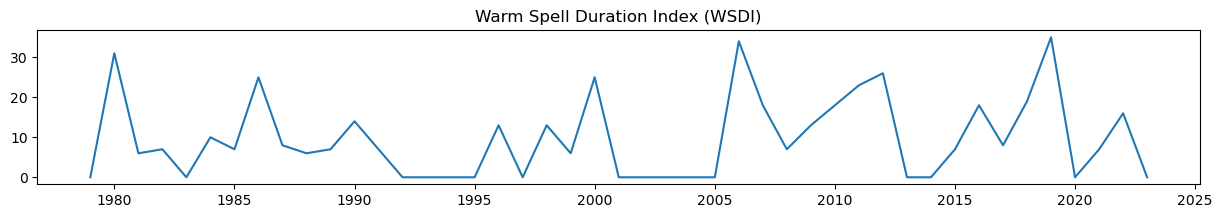

In [20]:
# plot it

# create annual datetimes for x axis values
time_annual=pd.date_range(tx.time.data[0],tx.time.data[-1],freq='YS')

# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,WSDI)
plt.title('Warm Spell Duration Index (WSDI)')
plt.show()

# Trend analysis

In [21]:
# linear regression
reg_info=ss.linregress(time_annual.year,WSDI)
trend=reg_info.slope*100 # days/year --> days/century
regline=reg_info.slope*time_annual.year +reg_info.intercept

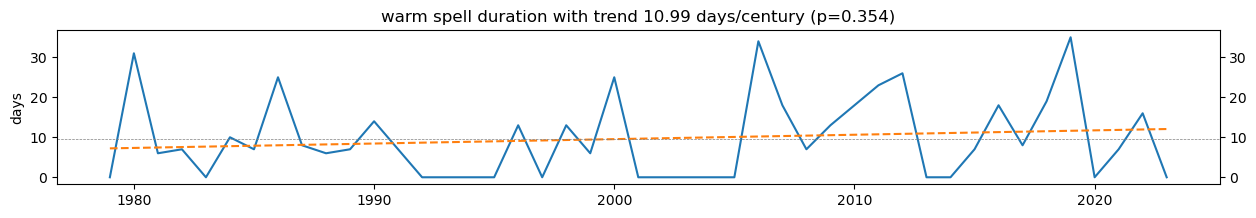

In [22]:
# plot the linear regression over the data and show p value
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual.year,WSDI) # plt.plot is from matplotlib.pyplot
plt.plot(time_annual.year,regline,linestyle='--')
plt.axhline(y=np.asarray(WSDI).mean(),color='grey',linestyle='dashed',linewidth=0.5)
plt.tick_params(labelright=True, right=True)
plt.ylabel('days')
plt.title(f'warm spell duration with trend {trend:.2f} days/century (p={reg_info.pvalue:.3f})')
plt.show()

The figure above shows that the increasing trend of 10.999 days/century in WSDI is meaningless because the trend is not statistically significant.